# Model Evaluation and Comparison

This notebook aggregates results from all experiments, compares their performance metrics (CV and Test), and visualizes key insights such as feature importance, cross-validation stability, and prediction distributions.

## Overview
We evaluate models across different categories:
- **Linear Models**: Logistic Regression, SVM
- **Tree Models**: Random Forest, XGBoost, LightGBM, CatBoost
- **Neural Networks**: MLP, CharCNN, BiLSTM, Hybrid
- **Transformers**: DeBERTa
- **Ensembles**: Simple Average, Weighted Average

In [12]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, log_loss
import joblib
import optuna
import optuna.visualization.matplotlib as vis

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Define experiment groups
EXPERIMENTS = {
    "Linear": [
        "exp_1_numeric_lr",
        "exp_1_tfidf_lr",
        "exp_1_combined_lr",
        "exp_1_combined_svm",
        "exp_1_combined_linear_svc_optuna"
    ],
    "Tree": [
        "exp_2_random_forest_numeric",
        "exp_2_random_forest_all",
        "exp_2_xgboost_all",
        "exp_2_lgbm_all",
        "exp_2_catboost_all",
        "exp_2_catboost_optuna"
    ],
    "Neural Network": [
        "exp_3_mlp_baseline",
        "exp_3_charcnn",
        "exp_3_bilstm",
        "exp_3_hybrid",
    ],
    "Transformer": [
        "exp_4_deberta_url_only",
        "exp_4_deberta_url_features"
    ],
    "Ensemble": [
        "exp_5_simple_avg",
        "exp_5_weighted_avg"
    ]
}

BASE_PATH = Path("experiments")
TEST_DATA_PATH = Path("dataset/df_test_feature_engineered.csv")

## Data Loading Functions

In [13]:
def load_metrics(exp_name):
    metrics_path = BASE_PATH / exp_name / "metrics.json"
    if not metrics_path.exists():
        # print(f"Warning: Metrics file not found for {exp_name}")
        return None
    
    with open(metrics_path, "r") as f:
        return json.load(f)

def get_test_labels():
    if not TEST_DATA_PATH.exists():
        print(f"Warning: Test data not found at {TEST_DATA_PATH}")
        return None
    
    try:
        df = pd.read_csv(TEST_DATA_PATH)
        if "target" in df.columns:
            return df["target"].values
        elif "label" in df.columns:
            return df["label"].values
        else:
            print("Error: Could not find target/label column in test data")
            return None
    except Exception as e:
        print(f"Error reading test data: {e}")
        return None

def evaluate_test_set(exp_name, y_true):
    pred_path = BASE_PATH / exp_name / f"{exp_name}_prediction.csv"
    if not pred_path.exists():
        # print(f"Warning: Prediction file not found for {exp_name}")
        return None
    
    try:
        preds_df = pd.read_csv(pred_path)
        
        # Extract probabilities
        if "probability" in preds_df.columns:
            y_scores = preds_df["probability"].astype(float).values
        elif "proba" in preds_df.columns:
            y_scores = preds_df["proba"].astype(float).values
        elif preds_df.shape[1] >= 2:
            y_scores = preds_df.iloc[:, -1].astype(float).values
        else:
            print(f"Error: Could not locate probability column for {exp_name}")
            return None
            
        # Ensure lengths match
        if len(y_scores) != len(y_true):
             min_len = min(len(y_scores), len(y_true))
             y_scores = y_scores[:min_len]
             y_true_eval = y_true[:min_len]
        else:
            y_true_eval = y_true

        # Calculate metrics
        metrics = {}
        metrics["roc_auc"] = roc_auc_score(y_true_eval, y_scores)
        metrics["log_loss"] = log_loss(y_true_eval, y_scores)
        
        # Threshold metrics (0.5)
        y_pred = (y_scores > 0.5).astype(int)
        metrics["accuracy"] = accuracy_score(y_true_eval, y_pred)
        metrics["recall"] = recall_score(y_true_eval, y_pred)
        metrics["precision"] = precision_score(y_true_eval, y_pred)
        metrics["f1"] = f1_score(y_true_eval, y_pred)
        
        return metrics

    except Exception as e:
        print(f"Error evaluating {exp_name}: {e}")
        return None

## 1. Metrics Comparison Table

We aggregate the average cross-validation metrics and calculate test set metrics for all models. This table provides a comprehensive view of model performance.

In [14]:
def create_metrics_table():
    y_true = get_test_labels()
    if y_true is None:
        print("Skipping test metrics due to missing labels")
    
    all_metrics = []
    
    for group, exp_list in EXPERIMENTS.items():
        for exp_name in exp_list:
            data = load_metrics(exp_name)
            
            # Handle ensemble experiments (no metrics.json file)
            if not data and group == "Ensemble":
                # Ensemble experiments only have test metrics
                test_metrics = {}
                if y_true is not None:
                    test_metrics = evaluate_test_set(exp_name, y_true) or {}
                
                if test_metrics:
                    row = {
                        "Group": group,
                        "Experiment": exp_name,
                        "Model": "Ensemble",
                        "Vectorizer": "N/A",
                        
                        # CV Metrics - N/A for ensemble
                        "CV ROC AUC": "N/A",
                        "CV Recall": "N/A",
                        "CV F1": "N/A",
                        
                        # Test Metrics
                        "Test ROC AUC": f"{test_metrics.get('roc_auc', 0):.4f}",
                        "Test Recall": f"{test_metrics.get('recall', 0):.4f}",
                        "Test F1": f"{test_metrics.get('f1', 0):.4f}",
                        
                        # Raw values for plotting
                        "_cv_roc_auc_val": 0,
                        "_test_roc_auc_val": test_metrics.get('roc_auc', 0),
                        "_cv_recall_val": 0,
                        "_test_recall_val": test_metrics.get('recall', 0)
                    }
                    all_metrics.append(row)
                continue
            
            if not data:
                continue
                
            avg_metrics = data.get("average_metrics", {})
            
            # Get test metrics
            test_metrics = {}
            if y_true is not None:
                test_metrics = evaluate_test_set(exp_name, y_true) or {}
            
            # Basic info
            row = {
                "Group": group,
                "Experiment": exp_name,
                "Model": data.get("model_type", "N/A"),
                "Vectorizer": data.get("vectorizer", "N/A"),
                
                # CV Metrics
                "CV ROC AUC": f"{avg_metrics.get('roc_auc', 0):.4f} ± {avg_metrics.get('roc_auc_std', 0):.4f}",
                "CV Recall": f"{avg_metrics.get('recall', 0):.4f} ± {avg_metrics.get('recall_std', 0):.4f}",
                "CV F1": f"{avg_metrics.get('f1', 0):.4f} ± {avg_metrics.get('f1_std', 0):.4f}",
                
                # Test Metrics
                "Test ROC AUC": f"{test_metrics.get('roc_auc', 0):.4f}" if test_metrics else "N/A",
                "Test Recall": f"{test_metrics.get('recall', 0):.4f}" if test_metrics else "N/A",
                "Test F1": f"{test_metrics.get('f1', 0):.4f}" if test_metrics else "N/A",
                
                # Raw values for sorting/plotting later (hidden in CSV usually, but good for DF)
                "_cv_roc_auc_val": avg_metrics.get('roc_auc', 0),
                "_test_roc_auc_val": test_metrics.get('roc_auc', 0) if test_metrics else 0,
                "_cv_recall_val": avg_metrics.get('recall', 0),
                "_test_recall_val": test_metrics.get('recall', 0) if test_metrics else 0
            }
            all_metrics.append(row)
            
    df = pd.DataFrame(all_metrics)
    return df

metrics_df = create_metrics_table()

# Display table
display_cols = [c for c in metrics_df.columns if not c.startswith("_")]
print(metrics_df[display_cols].to_markdown(index=False))

| Group          | Experiment                       | Model               | Vectorizer               | CV ROC AUC      | CV Recall       | CV F1           |   Test ROC AUC |   Test Recall |   Test F1 |
|:---------------|:---------------------------------|:--------------------|:-------------------------|:----------------|:----------------|:----------------|---------------:|--------------:|----------:|
| Linear         | exp_1_numeric_lr                 | LogisticRegression  | NumericFeatures          | 0.9423 ± 0.0033 | 0.8460 ± 0.0095 | 0.8627 ± 0.0038 |         0.9418 |        0.8443 |    0.8624 |
| Linear         | exp_1_tfidf_lr                   | LogisticRegression  | TfidfVectorizer          | 0.9664 ± 0.0036 | 0.9000 ± 0.0128 | 0.8998 ± 0.0059 |         0.9715 |        0.9134 |    0.9078 |
| Linear         | exp_1_combined_lr                | LogisticRegression  | CombinedFeatures         | 0.9796 ± 0.0022 | 0.9217 ± 0.0070 | 0.9273 ± 0.0031 |         0.9805 |        0.9178 |   

## 2. Cross-Validation Stability (ROC AUC Boxplot)

This plot shows the distribution of ROC AUC scores across the 5 folds for each experiment, highlighting the stability and variance of each model. Note that Ensemble models are not included here as they do not have fold-wise metrics.

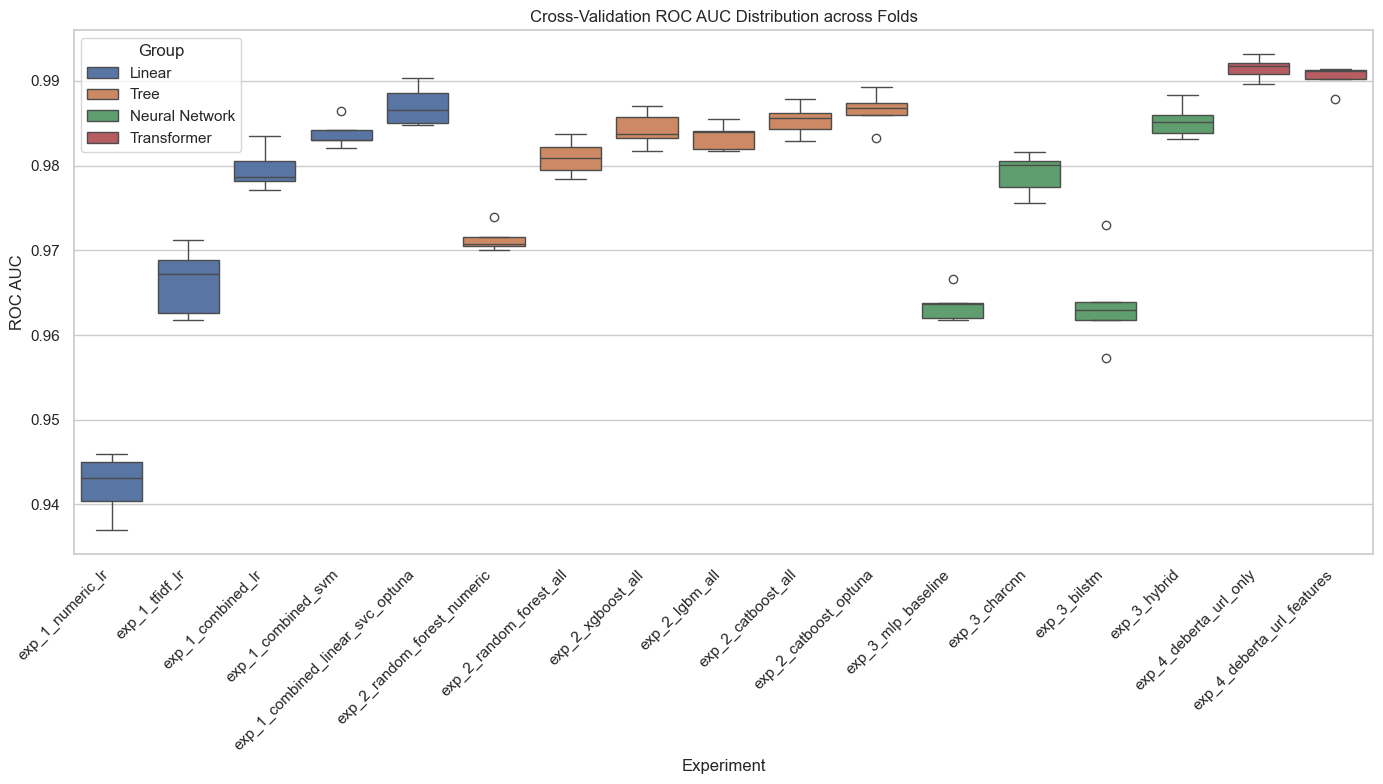

In [15]:
def plot_cv_roc_auc_boxplot():
    plot_data = []
    
    for group, exp_list in EXPERIMENTS.items():
        for exp_name in exp_list:
            data = load_metrics(exp_name)
            if not data:
                continue
            
            fold_metrics = data.get("fold_metrics", [])
            for fold in fold_metrics:
                plot_data.append({
                    "Experiment": exp_name,
                    "Group": group,
                    "ROC AUC": fold.get("roc_auc", 0)
                })
                
    df_plot = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df_plot, x="Experiment", y="ROC AUC", hue="Group", dodge=False)
    plt.xticks(rotation=45, ha="right")
    plt.title("Cross-Validation ROC AUC Distribution across Folds")
    plt.tight_layout()
    plt.show()

plot_cv_roc_auc_boxplot()

## 3. CV vs Test Performance Comparison

We compare the Cross-Validation (mean) performance against the Test Set performance for ROC AUC and Recall. This helps identify overfitting (if CV >> Test) or generalization capability.

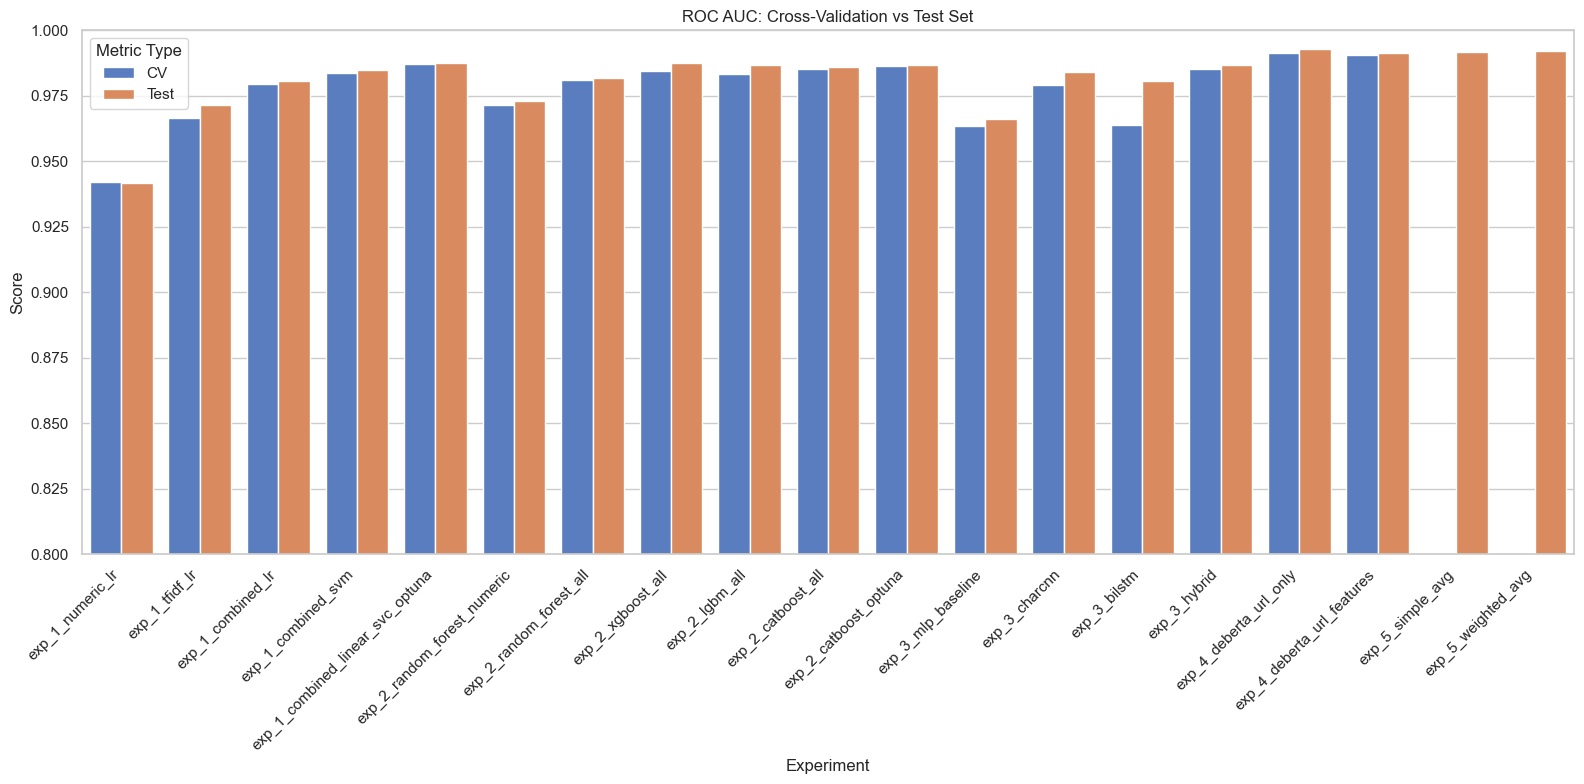

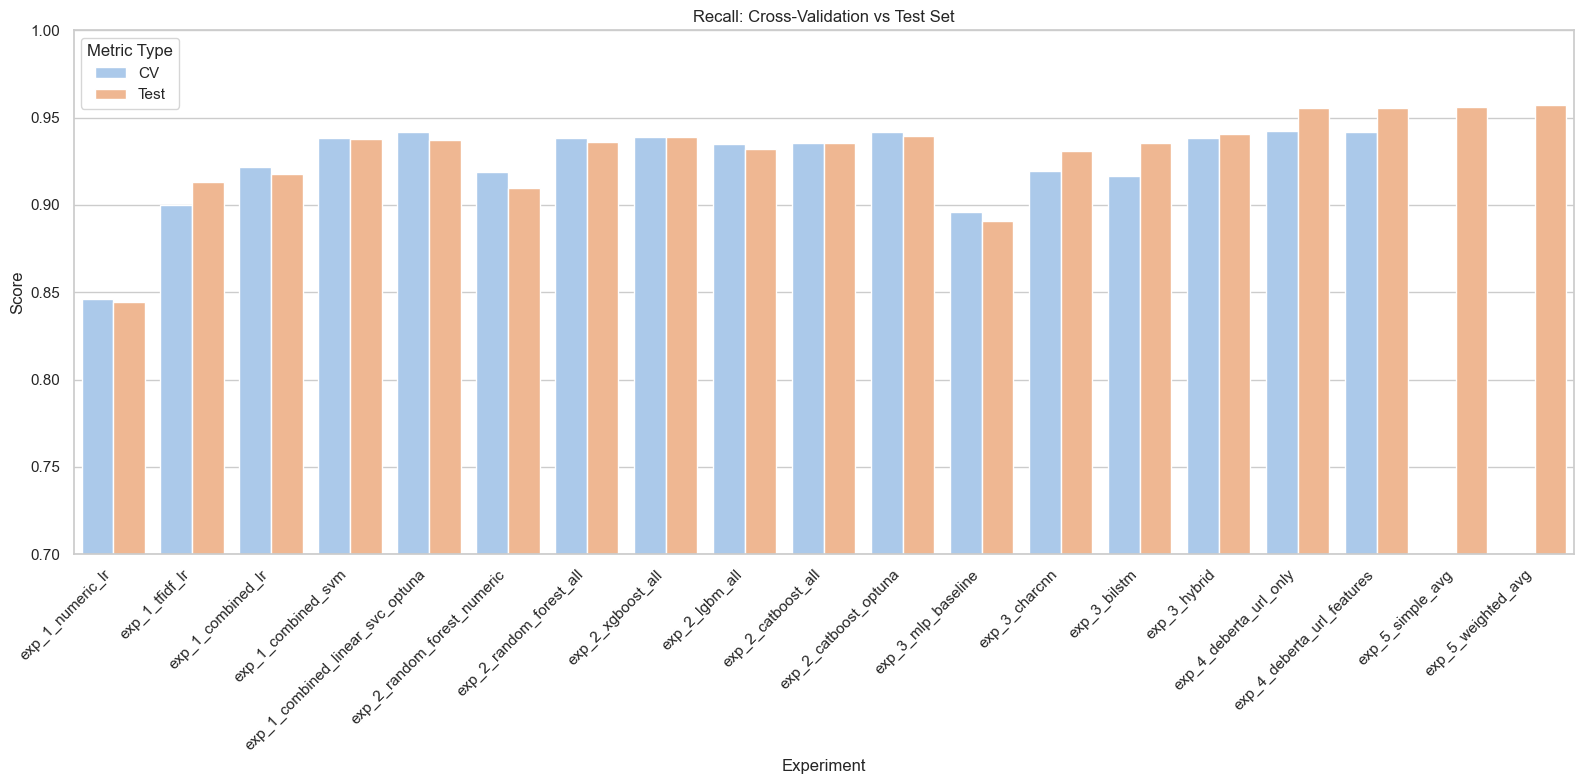

In [16]:
def plot_cv_vs_test_performance(df_metrics):
    # Get test labels for ensemble experiments
    y_true = get_test_labels()
    
    # Filter out rows without test metrics
    df_plot = df_metrics[df_metrics["Test ROC AUC"] != "N/A"].copy()
    
    # Add ensemble experiments if they have prediction files
    ensemble_data = []
    if y_true is not None:
        for exp_name in EXPERIMENTS.get("Ensemble", []):
            test_metrics = evaluate_test_set(exp_name, y_true)
            if test_metrics:
                ensemble_data.append({
                    "Experiment": exp_name,
                    "Group": "Ensemble",
                    "_cv_roc_auc_val": 0,  # No CV metrics
                    "_test_roc_auc_val": test_metrics.get("roc_auc", 0),
                    "_cv_recall_val": 0,  # No CV metrics
                    "_test_recall_val": test_metrics.get("recall", 0)
                })
    
    if ensemble_data:
        df_ensemble = pd.DataFrame(ensemble_data)
        df_plot = pd.concat([df_plot, df_ensemble], ignore_index=True)
    
    if df_plot.empty:
        print("No test metrics available for plotting.")
        return

    # Prepare data for plotting (melt)
    # ROC AUC
    roc_data = []
    for _, row in df_plot.iterrows():
        # Only add CV bar if CV value exists (non-zero for non-ensemble)
        if row["_cv_roc_auc_val"] > 0:
            roc_data.append({
                "Experiment": row["Experiment"],
                "Group": row["Group"],
                "Metric Type": "CV",
                "Score": row["_cv_roc_auc_val"]
            })
        # Always add test bar
        roc_data.append({
            "Experiment": row["Experiment"],
            "Group": row["Group"],
            "Metric Type": "Test",
            "Score": row["_test_roc_auc_val"]
        })
    
    df_roc = pd.DataFrame(roc_data)
    
    # Plot ROC AUC
    plt.figure(figsize=(16, 8))
    sns.barplot(data=df_roc, x="Experiment", y="Score", hue="Metric Type", palette="muted")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0.8, 1.0) # Zoom in as scores are likely high
    plt.title("ROC AUC: Cross-Validation vs Test Set")
    plt.tight_layout()
    plt.show()
    
    # Recall
    recall_data = []
    for _, row in df_plot.iterrows():
        # Only add CV bar if CV value exists (non-zero for non-ensemble)
        if row["_cv_recall_val"] > 0:
            recall_data.append({
                "Experiment": row["Experiment"],
                "Group": row["Group"],
                "Metric Type": "CV",
                "Score": row["_cv_recall_val"]
            })
        # Always add test bar
        recall_data.append({
            "Experiment": row["Experiment"],
            "Group": row["Group"],
            "Metric Type": "Test",
            "Score": row["_test_recall_val"]
        })
        
    df_recall = pd.DataFrame(recall_data)
    
    # Plot Recall
    plt.figure(figsize=(16, 8))
    sns.barplot(data=df_recall, x="Experiment", y="Score", hue="Metric Type", palette="pastel")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0.7, 1.0)
    plt.title("Recall: Cross-Validation vs Test Set")
    plt.tight_layout()
    plt.show()

plot_cv_vs_test_performance(metrics_df)

## 4. Feature Importance Analysis

We analyze the feature importance for the tree-based models (CatBoost, XGBoost, LightGBM, Random Forest). We use the model from the best performing fold.

/var/folders/tg/0n0rjzh11yd7zhlhtlf2g84r0000gn/T/ipykernel_19698/1171466510.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp.head(20), x="Importance", y="Feature", palette="viridis")


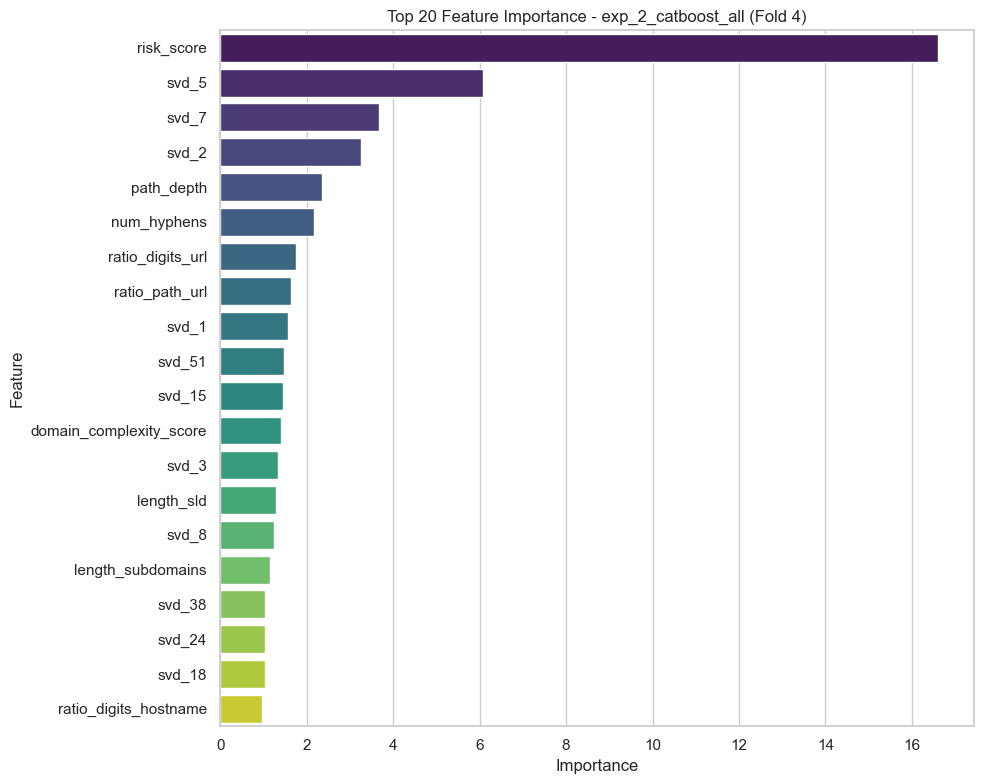

/var/folders/tg/0n0rjzh11yd7zhlhtlf2g84r0000gn/T/ipykernel_19698/1171466510.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp.head(20), x="Importance", y="Feature", palette="viridis")


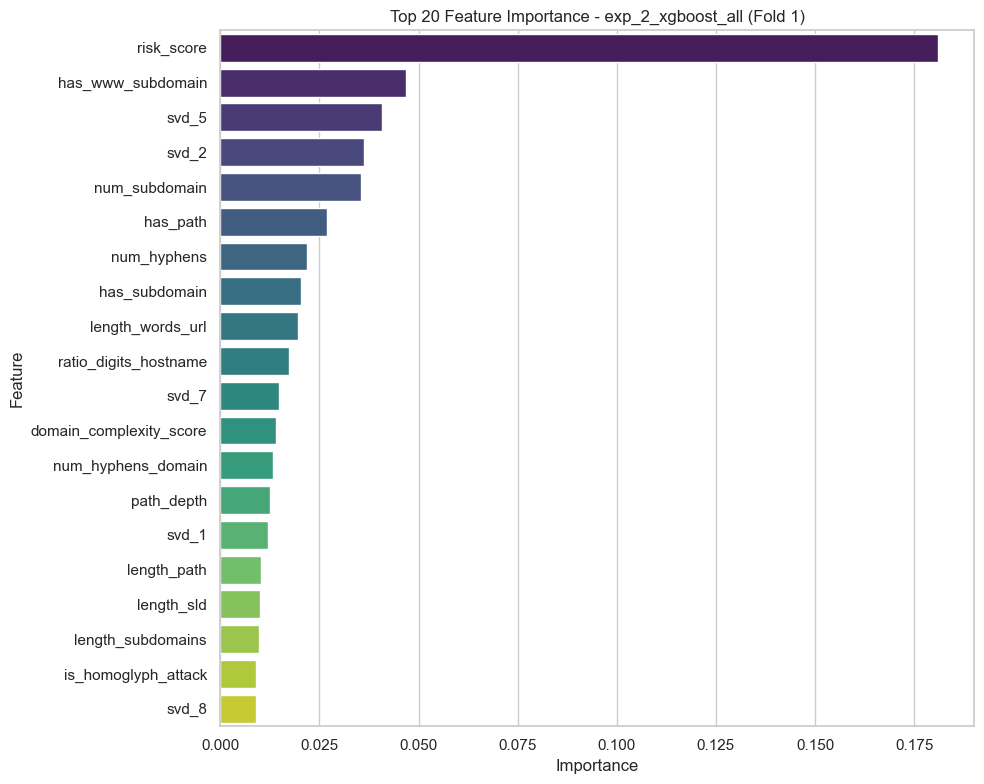

/var/folders/tg/0n0rjzh11yd7zhlhtlf2g84r0000gn/T/ipykernel_19698/1171466510.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp.head(20), x="Importance", y="Feature", palette="viridis")


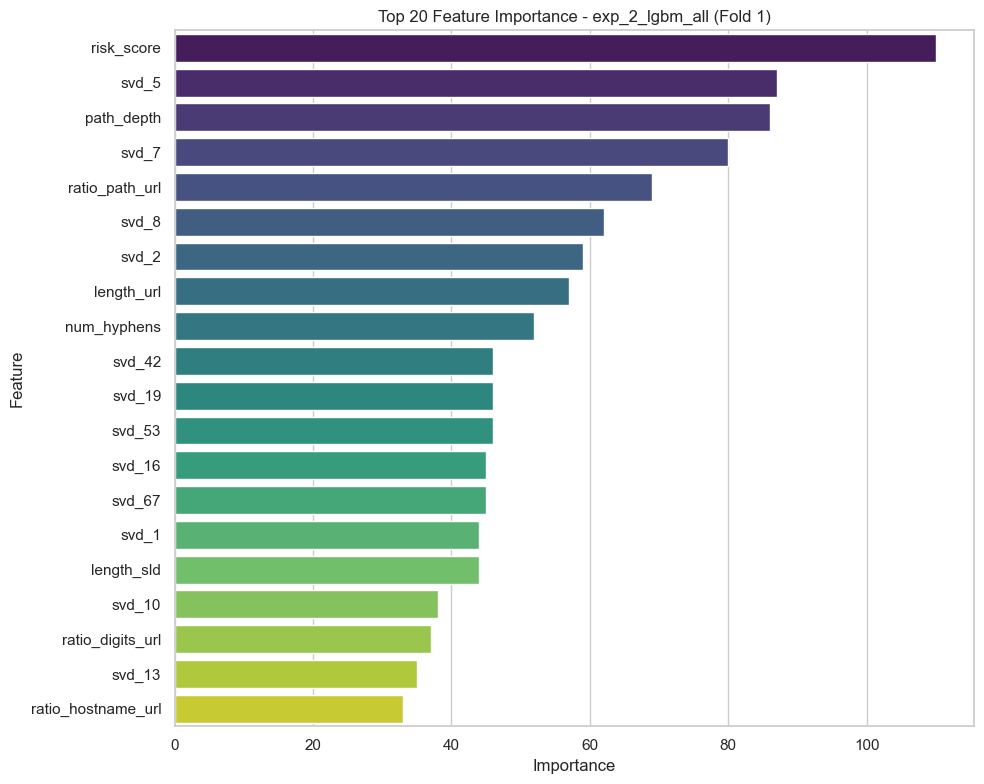

/var/folders/tg/0n0rjzh11yd7zhlhtlf2g84r0000gn/T/ipykernel_19698/1171466510.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp.head(20), x="Importance", y="Feature", palette="viridis")


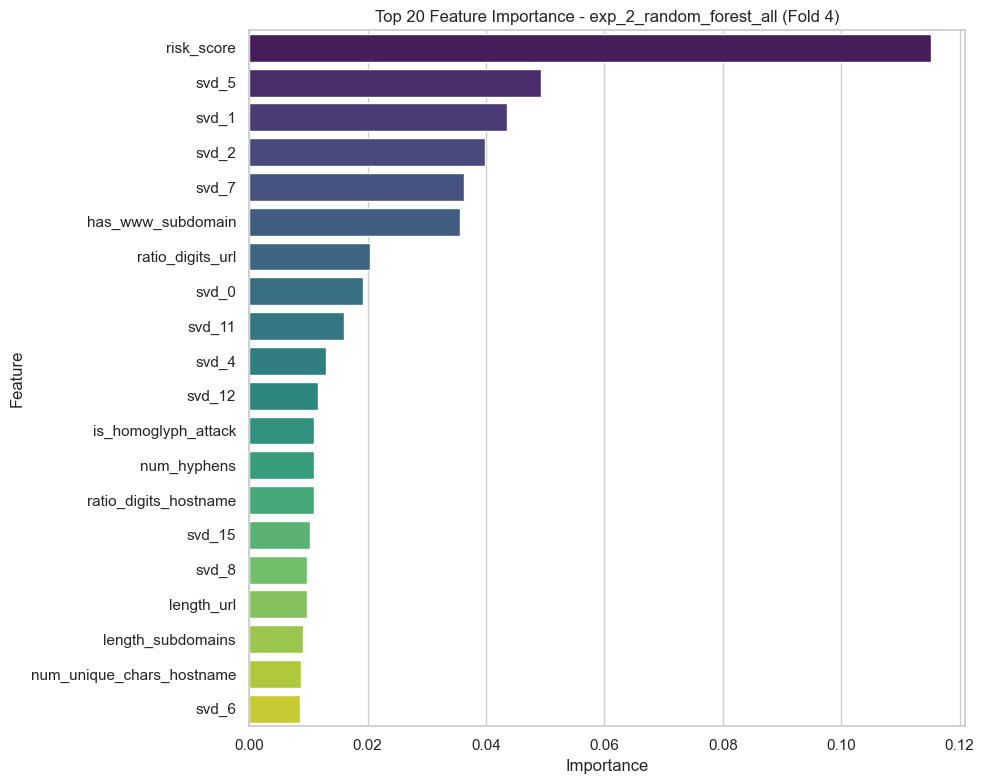

In [17]:
def get_feature_importance(pipeline, feature_names):
    # Try to find the model step
    model = None
    if hasattr(pipeline, "named_steps"):
        if "model" in pipeline.named_steps:
            model = pipeline.named_steps["model"]
        elif "classifier" in pipeline.named_steps:
            model = pipeline.named_steps["classifier"]
        else:
            # Last step is usually the model
            model = pipeline.steps[-1][1]
    else:
        model = pipeline

    # Extract importance
    importances = None
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0])
    
    if importances is None:
        return None
        
    # Match with feature names
    if len(importances) != len(feature_names):
        print(f"Warning: Feature count mismatch. Model: {len(importances)}, Names: {len(feature_names)}")
        return None
        
    return pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

def plot_feature_importance():
    # Only for tree models as requested
    target_models = [
        "exp_2_catboost_all",
        "exp_2_xgboost_all",
        "exp_2_lgbm_all",
        "exp_2_random_forest_all"
    ]
    
    for exp_name in target_models:
        # print(f"Processing {exp_name}...")
        exp_dir = BASE_PATH / exp_name
        
        # Load feature names
        feat_file = exp_dir / "feature_names_all_folds.json"
        if not feat_file.exists():
            print(f"  Feature names file not found for {exp_name}")
            continue
            
        with open(feat_file, "r") as f:
            feat_data = json.load(f)
            
        # Load metrics to find best fold
        metrics_data = load_metrics(exp_name)
        best_fold = metrics_data.get("best_fold", 1)
        
        # Get features for best fold
        feature_names = next((f["features"] for f in feat_data if f["fold"] == best_fold), None)
        if not feature_names:
            print(f"  Could not find feature names for fold {best_fold}")
            continue
            
        # Load pipeline for best fold
        pipeline_path = exp_dir / f"pipeline_fold_{best_fold}.pkl"
        if not pipeline_path.exists():
            print(f"  Pipeline file not found: {pipeline_path}")
            continue
            
        try:
            with open(pipeline_path, "rb") as f:
                pipeline = pickle.load(f)
        except Exception as e:
            print(f"  Error loading pipeline: {e}")
            continue
            
        # Get importance
        df_imp = get_feature_importance(pipeline, feature_names)
        if df_imp is None:
            print(f"  Could not extract feature importance for {exp_name}")
            continue
            
        # Plot top 20
        plt.figure(figsize=(10, 8))
        sns.barplot(data=df_imp.head(20), x="Importance", y="Feature", palette="viridis")
        plt.title(f"Top 20 Feature Importance - {exp_name} (Fold {best_fold})")
        plt.tight_layout()
        plt.show()

plot_feature_importance()

## 5. Submission Probability Distributions

We visualize the distribution of predicted probabilities for each experiment's submission file. This helps understand model confidence and calibration.

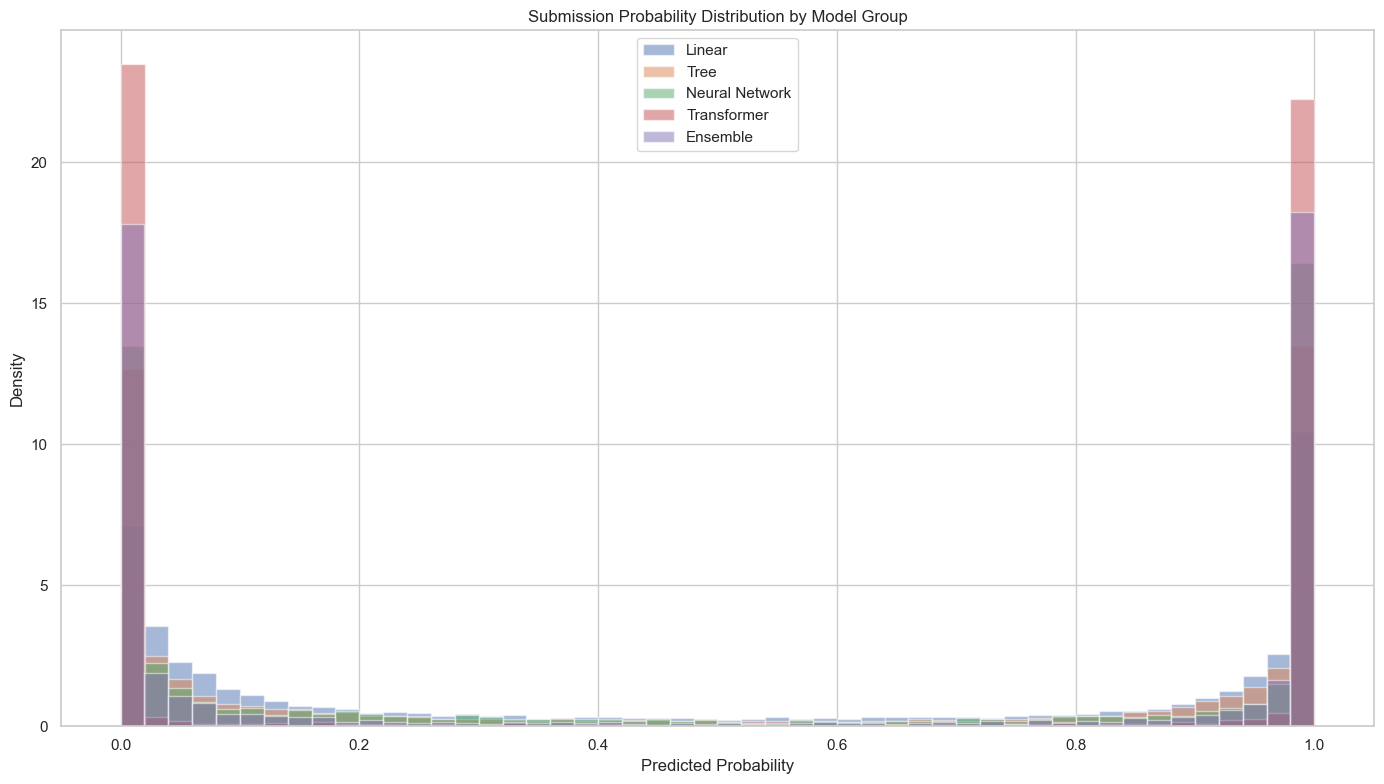

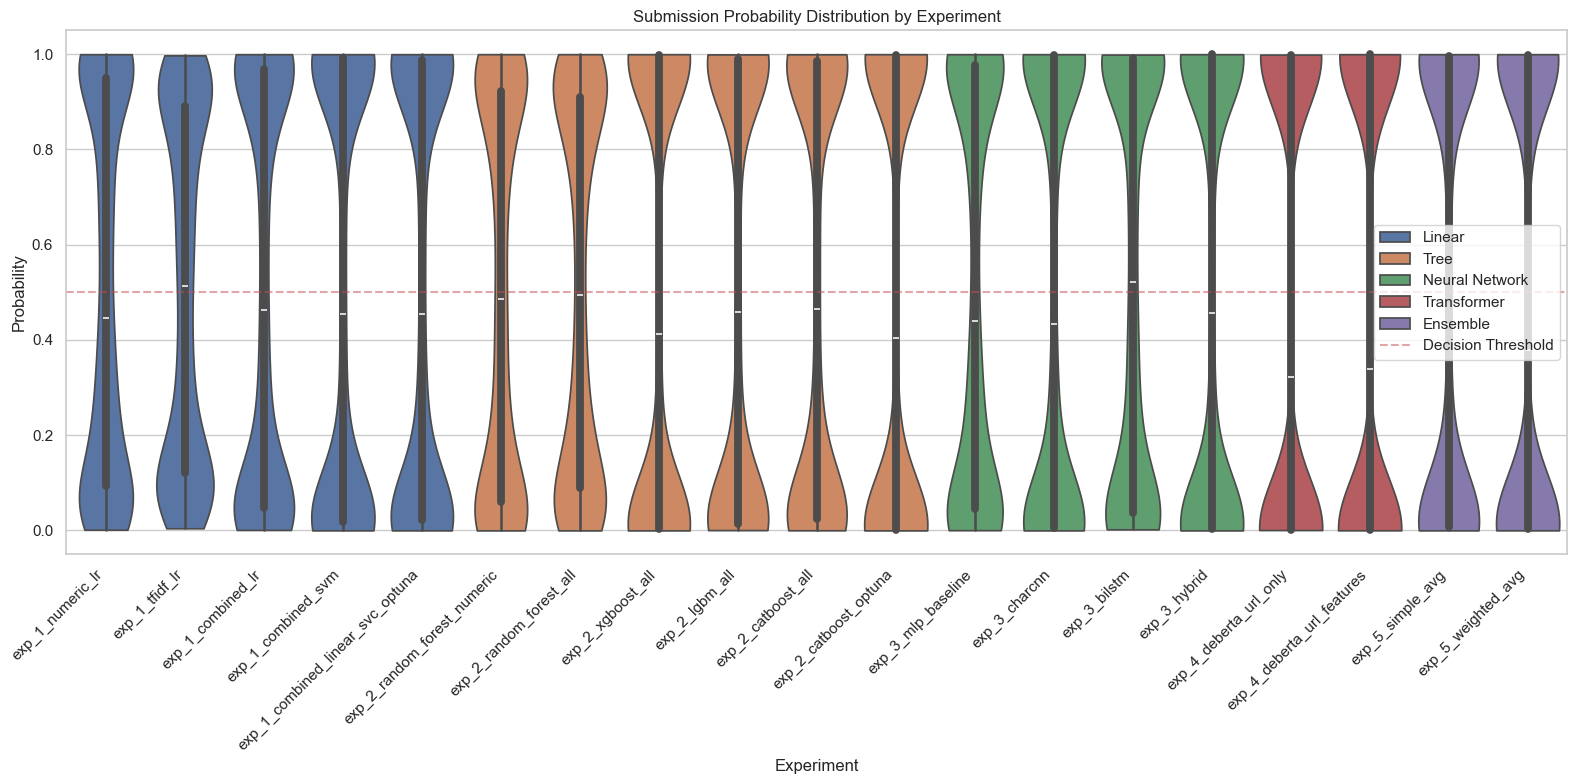

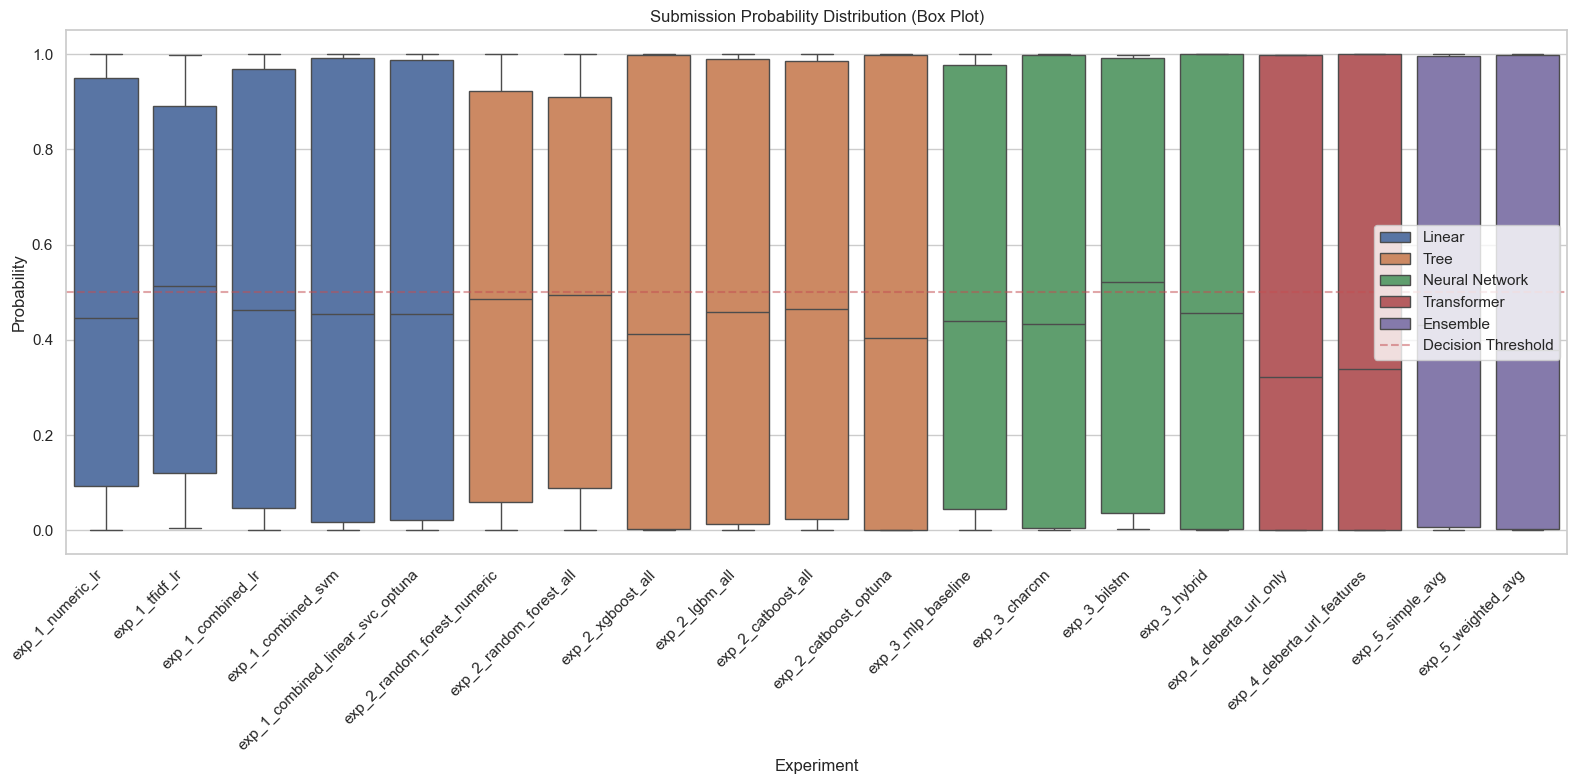

In [18]:
def plot_submission_distributions():
    all_predictions = []
    
    for group, exp_list in EXPERIMENTS.items():
        for exp_name in exp_list:
            pred_path = BASE_PATH / exp_name / f"{exp_name}_prediction.csv"
            if not pred_path.exists():
                # print(f"Warning: Prediction file not found for {exp_name}")
                continue
            
            try:
                preds_df = pd.read_csv(pred_path)
                
                # Extract probabilities
                if "probability" in preds_df.columns:
                    y_scores = preds_df["probability"].astype(float).values
                elif "proba" in preds_df.columns:
                    y_scores = preds_df["proba"].astype(float).values
                elif preds_df.shape[1] >= 2:
                    y_scores = preds_df.iloc[:, -1].astype(float).values
                else:
                    print(f"  Could not locate probability column for {exp_name}")
                    continue
                
                for score in y_scores:
                    all_predictions.append({
                        "Experiment": exp_name,
                        "Group": group,
                        "Probability": score
                    })
                    
            except Exception as e:
                print(f"  Error reading predictions for {exp_name}: {e}")
                continue
    
    if not all_predictions:
        print("No predictions found to plot")
        return
    
    df_preds = pd.DataFrame(all_predictions)
    
    # Plot 1: Distribution by group
    plt.figure(figsize=(14, 8))
    for group in df_preds["Group"].unique():
        group_data = df_preds[df_preds["Group"] == group]
        plt.hist(group_data["Probability"], bins=50, alpha=0.5, label=group, density=True)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.title("Submission Probability Distribution by Model Group")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Individual violin plots for each experiment
    plt.figure(figsize=(16, 8))
    sns.violinplot(data=df_preds, x="Experiment", y="Probability", hue="Group", dodge=False, cut=0)
    plt.xticks(rotation=45, ha="right")
    plt.title("Submission Probability Distribution by Experiment")
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Decision Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Box plot showing quartiles
    plt.figure(figsize=(16, 8))
    sns.boxplot(data=df_preds, x="Experiment", y="Probability", hue="Group", dodge=False)
    plt.xticks(rotation=45, ha="right")
    plt.title("Submission Probability Distribution (Box Plot)")
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Decision Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_submission_distributions()

## 6. Feature Type Comparison

We compare performance across different feature sets:
- **Engineered Features**: Hand-crafted features
- **URL Only**: Raw URL text features (TF-IDF, Embeddings)
- **Combined Features**: Both engineered and URL features

/var/folders/tg/0n0rjzh11yd7zhlhtlf2g84r0000gn/T/ipykernel_19698/650032339.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_feature, x="Feature Type", y="Test ROC AUC", ax=axes[0], palette="Set2")
/var/folders/tg/0n0rjzh11yd7zhlhtlf2g84r0000gn/T/ipykernel_19698/650032339.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_feature, x="Feature Type", y="Test Recall", ax=axes[1], palette="Set2")


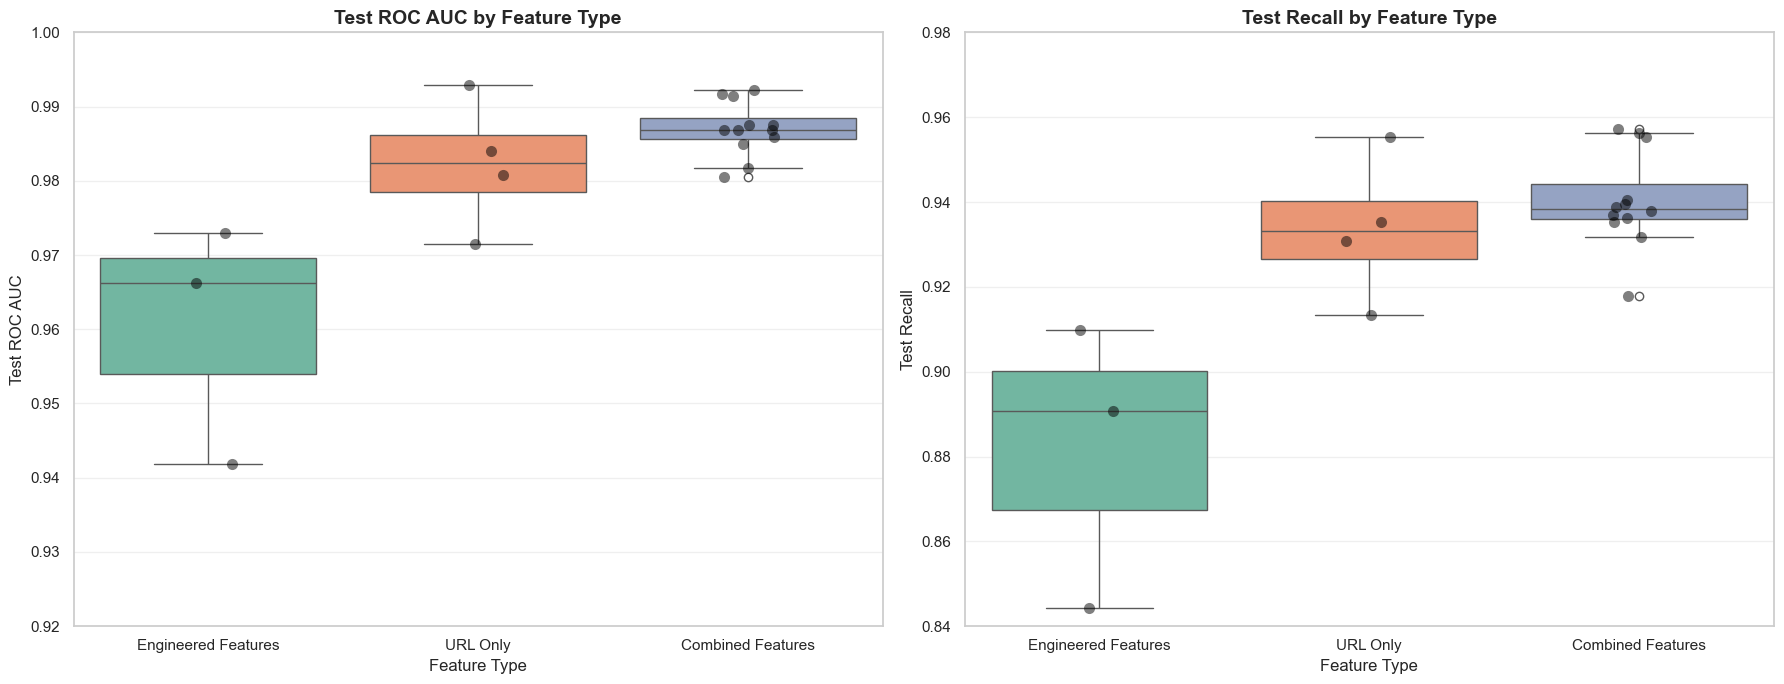

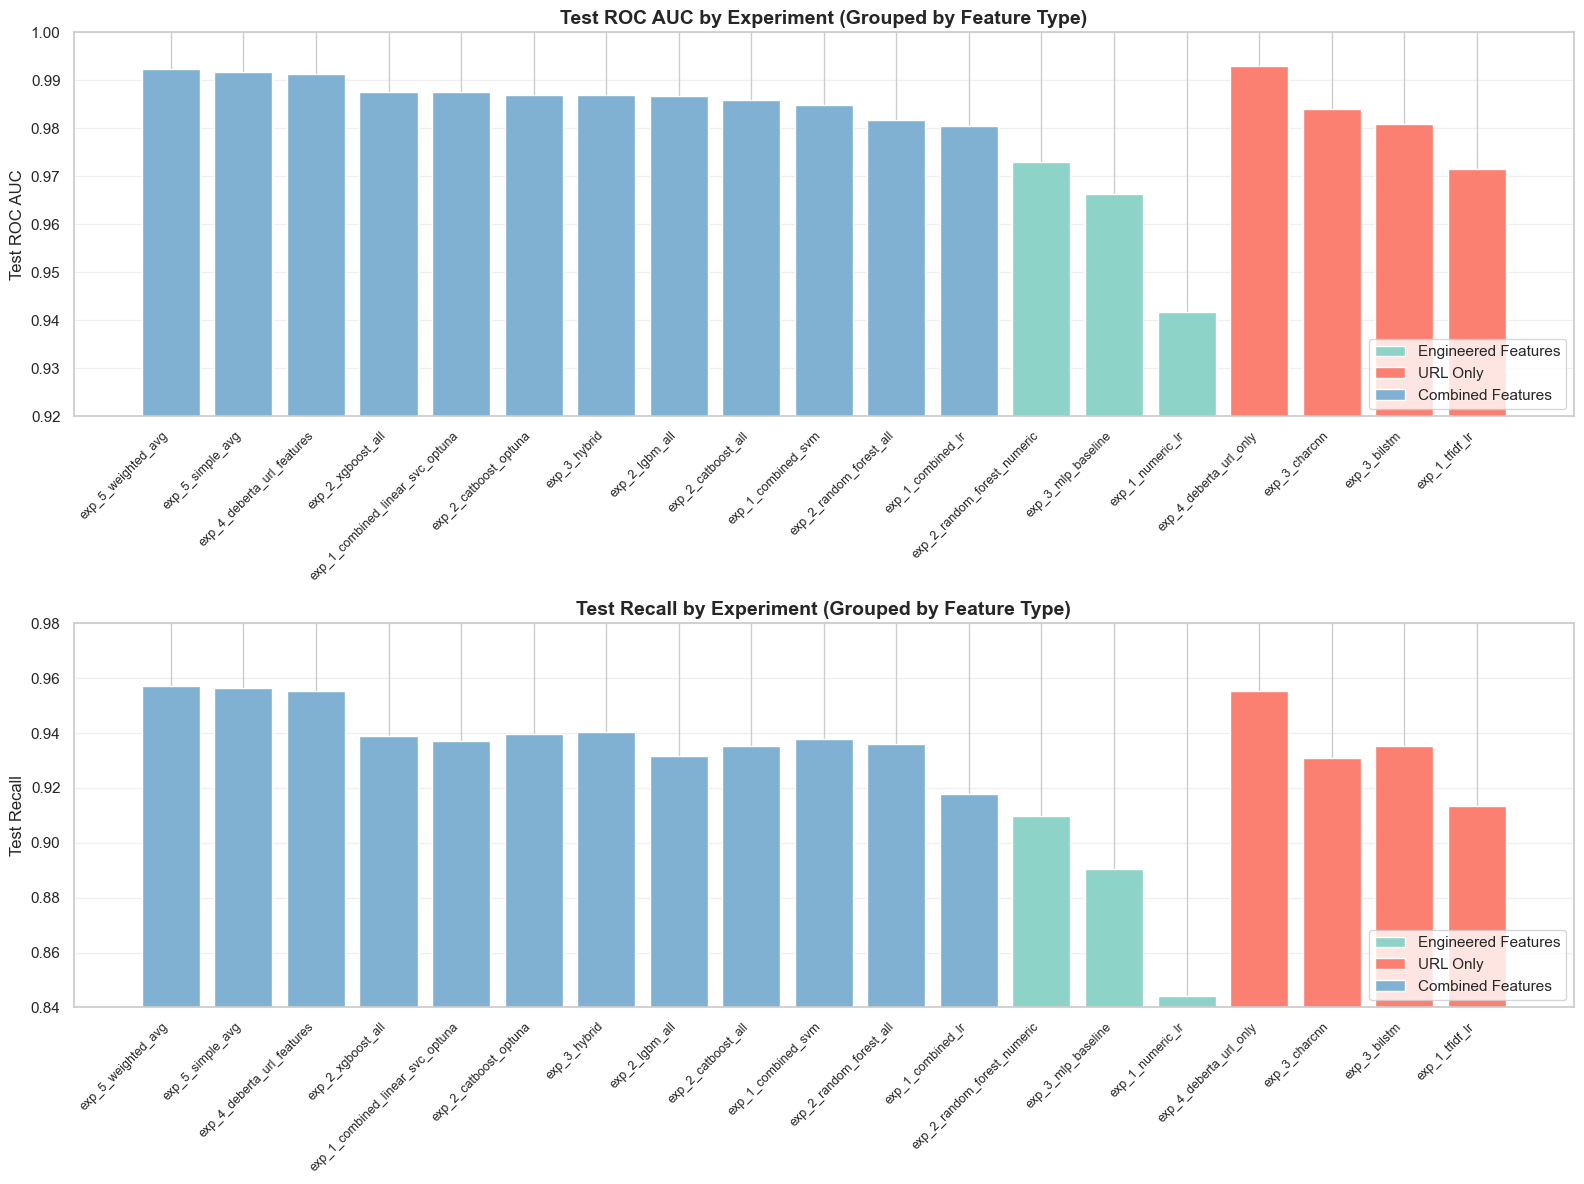


=== Feature Type Summary Statistics ===

Engineered Features:
  ROC AUC - Mean: 0.9603, Std: 0.0164
  Recall  - Mean: 0.8816, Std: 0.0337
  Count: 3 experiments

URL Only:
  ROC AUC - Mean: 0.9823, Std: 0.0088
  Recall  - Mean: 0.9337, Std: 0.0173
  Count: 4 experiments

Combined Features:
  ROC AUC - Mean: 0.9870, Std: 0.0036
  Recall  - Mean: 0.9403, Std: 0.0113
  Count: 12 experiments


In [19]:
def plot_feature_type_comparison(df_metrics):
    # Define feature type groups
    FEATURE_GROUPS = {
        "Engineered Features": [
            "exp_1_numeric_lr",
            "exp_2_random_forest_numeric",
            "exp_3_mlp_baseline"
        ],
        "URL Only": [
            "exp_1_tfidf_lr",
            "exp_3_charcnn",
            "exp_3_bilstm",
            "exp_4_deberta_url_only"
        ],
        "Combined Features": [
            "exp_1_combined_lr",
            "exp_1_combined_svm",
            "exp_1_combined_linear_svc_optuna",
            "exp_2_random_forest_all",
            "exp_2_xgboost_all",
            "exp_2_lgbm_all",
            "exp_2_catboost_all",
            "exp_2_catboost_optuna",
            "exp_3_hybrid",
            "exp_4_deberta_url_features",
            "exp_5_simple_avg",
            "exp_5_weighted_avg"
        ]
    }
    
    # Get test labels for ensemble experiments
    y_true = get_test_labels()
    
    # Prepare data
    feature_type_data = []
    
    for feature_type, exp_list in FEATURE_GROUPS.items():
        for exp_name in exp_list:
            # Try to get from df_metrics first
            row = df_metrics[df_metrics["Experiment"] == exp_name]
            
            if not row.empty and row.iloc[0]["Test ROC AUC"] != "N/A":
                feature_type_data.append({
                    "Feature Type": feature_type,
                    "Experiment": exp_name,
                    "Test ROC AUC": row.iloc[0]["_test_roc_auc_val"],
                    "Test Recall": row.iloc[0]["_test_recall_val"]
                })
            elif y_true is not None:
                # Try to evaluate test set (for ensemble experiments)
                test_metrics = evaluate_test_set(exp_name, y_true)
                if test_metrics:
                    feature_type_data.append({
                        "Feature Type": feature_type,
                        "Experiment": exp_name,
                        "Test ROC AUC": test_metrics.get("roc_auc", 0),
                        "Test Recall": test_metrics.get("recall", 0)
                    })
    
    if not feature_type_data:
        print("No test metrics available for feature type comparison")
        return
    
    df_feature = pd.DataFrame(feature_type_data)
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot 1: ROC AUC by Feature Type
    sns.boxplot(data=df_feature, x="Feature Type", y="Test ROC AUC", ax=axes[0], palette="Set2")
    sns.stripplot(data=df_feature, x="Feature Type", y="Test ROC AUC", ax=axes[0], 
                  color="black", alpha=0.5, size=8)
    axes[0].set_title("Test ROC AUC by Feature Type", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Test ROC AUC", fontsize=12)
    axes[0].set_xlabel("Feature Type", fontsize=12)
    axes[0].set_ylim(0.92, 1.0)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Recall by Feature Type
    sns.boxplot(data=df_feature, x="Feature Type", y="Test Recall", ax=axes[1], palette="Set2")
    sns.stripplot(data=df_feature, x="Feature Type", y="Test Recall", ax=axes[1], 
                  color="black", alpha=0.5, size=8)
    axes[1].set_title("Test Recall by Feature Type", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("Test Recall", fontsize=12)
    axes[1].set_xlabel("Feature Type", fontsize=12)
    axes[1].set_ylim(0.84, 0.98)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create a detailed bar plot showing all experiments grouped by feature type
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Sort by feature type for better visualization
    df_feature_sorted = df_feature.sort_values(["Feature Type", "Test ROC AUC"], ascending=[True, False])
    
    # Plot 1: ROC AUC
    colors = {"Engineered Features": "#8dd3c7", "URL Only": "#fb8072", "Combined Features": "#80b1d3"}
    bar_colors = [colors[ft] for ft in df_feature_sorted["Feature Type"]]
    
    axes[0].bar(range(len(df_feature_sorted)), df_feature_sorted["Test ROC AUC"], color=bar_colors)
    axes[0].set_xticks(range(len(df_feature_sorted)))
    axes[0].set_xticklabels(df_feature_sorted["Experiment"], rotation=45, ha="right", fontsize=9)
    axes[0].set_ylabel("Test ROC AUC", fontsize=12)
    axes[0].set_title("Test ROC AUC by Experiment (Grouped by Feature Type)", fontsize=14, fontweight='bold')
    axes[0].set_ylim(0.92, 1.0)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[ft], label=ft) for ft in colors.keys()]
    axes[0].legend(handles=legend_elements, loc='lower right')
    
    # Plot 2: Recall
    axes[1].bar(range(len(df_feature_sorted)), df_feature_sorted["Test Recall"], color=bar_colors)
    axes[1].set_xticks(range(len(df_feature_sorted)))
    axes[1].set_xticklabels(df_feature_sorted["Experiment"], rotation=45, ha="right", fontsize=9)
    axes[1].set_ylabel("Test Recall", fontsize=12)
    axes[1].set_title("Test Recall by Experiment (Grouped by Feature Type)", fontsize=14, fontweight='bold')
    axes[1].set_ylim(0.84, 0.98)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Feature Type Summary Statistics ===")
    for feature_type in FEATURE_GROUPS.keys():
        ft_data = df_feature[df_feature["Feature Type"] == feature_type]
        if not ft_data.empty:
            print(f"\n{feature_type}:")
            print(f"  ROC AUC - Mean: {ft_data['Test ROC AUC'].mean():.4f}, Std: {ft_data['Test ROC AUC'].std():.4f}")
            print(f"  Recall  - Mean: {ft_data['Test Recall'].mean():.4f}, Std: {ft_data['Test Recall'].std():.4f}")
            print(f"  Count: {len(ft_data)} experiments")

plot_feature_type_comparison(metrics_df)

## 7. Hyperparameter Tuning Analysis (Optuna)

We visualize the hyperparameter importance for the Linear SVC model tuned with Optuna.

Loading study from experiments/exp_1_combined_linear_svc_optuna/optuna_study.pkl...
Joblib load successful
Loaded study with 60 trials


/var/folders/tg/0n0rjzh11yd7zhlhtlf2g84r0000gn/T/ipykernel_19698/1476200108.py:29: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  ax = vis.plot_param_importances(study)


<Figure size 1200x800 with 0 Axes>

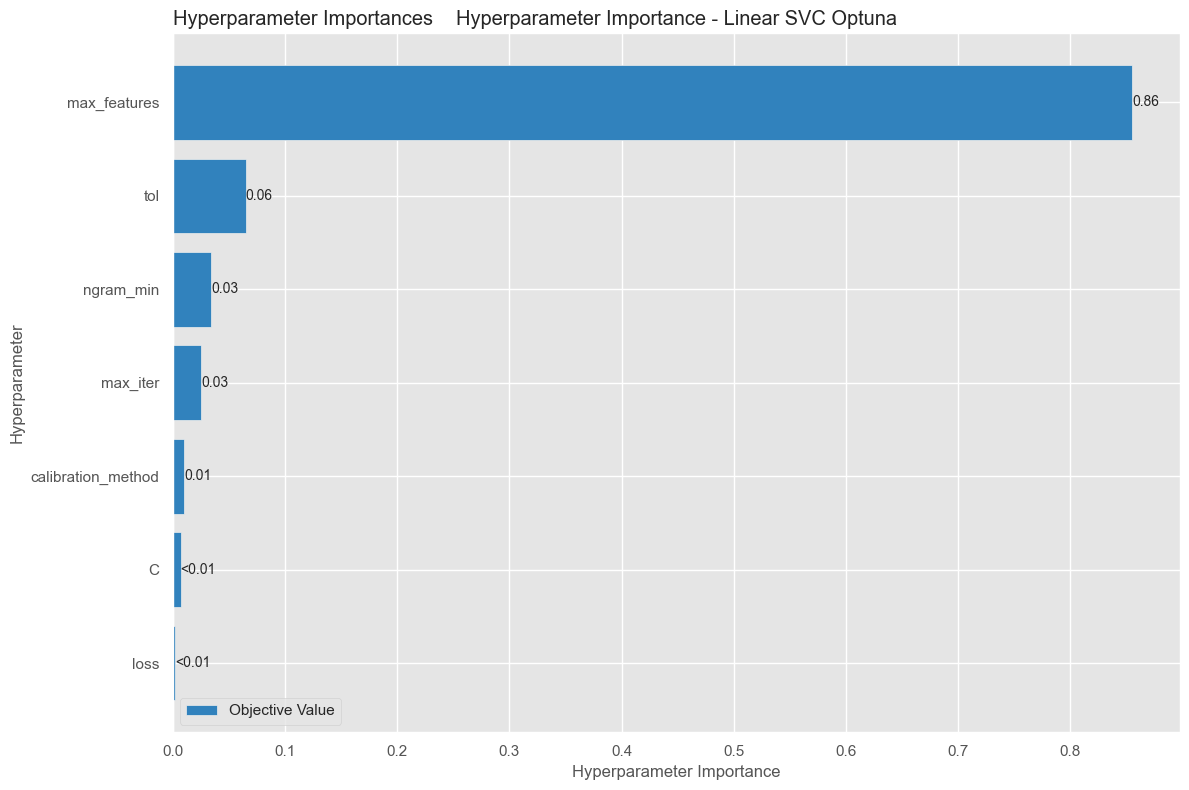

Loading study from experiments/exp_2_catboost_optuna/optuna_study.pkl...
Loaded study with 60 trials


/var/folders/tg/0n0rjzh11yd7zhlhtlf2g84r0000gn/T/ipykernel_19698/1476200108.py:29: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  ax = vis.plot_param_importances(study)


<Figure size 1200x800 with 0 Axes>

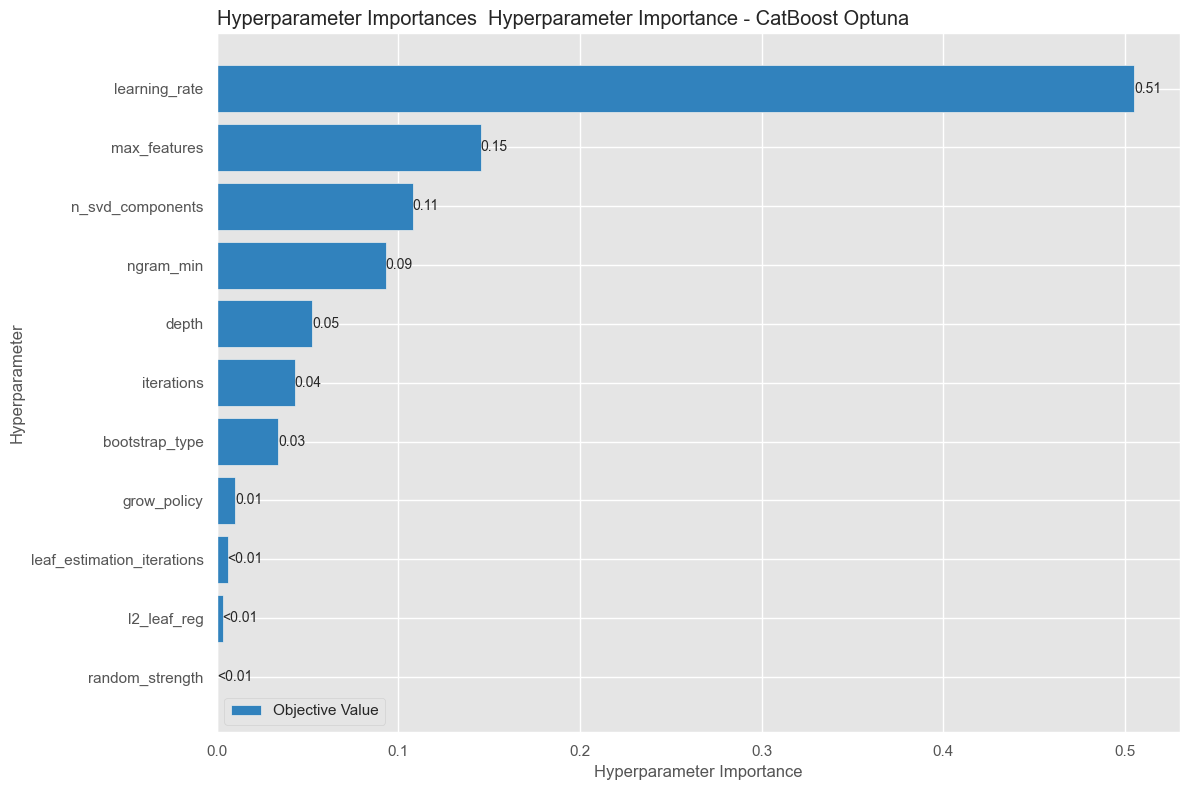

In [20]:
def plot_optuna_importance(study_path, exp_name):

    if not Path(study_path).exists():
        print(f"Error: File not found at {study_path}")
        return

    print(f"Loading study from {study_path}...")

    # Try loading
    study = None
    try:
        with open(study_path, "rb") as f:
            study = pickle.load(f)
    except Exception as e:
        # print(f"Pickle load failed: {e}")
        try:
            study = joblib.load(study_path)
            print("Joblib load successful")
        except Exception as e2:
            print(f"Joblib load failed: {e2}")
            return

    print(f"Loaded study with {len(study.trials)} trials")

    # Plot
    try:
        plt.figure(figsize=(12, 8))
        # plot_param_importances returns an Axes object
        ax = vis.plot_param_importances(study)
        ax.set_title(f"Hyperparameter Importance - {exp_name}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting: {e}")

linear_svc_study_path = "experiments/exp_1_combined_linear_svc_optuna/optuna_study.pkl"
catboost_study_path = "experiments/exp_2_catboost_optuna/optuna_study.pkl"

plot_optuna_importance(linear_svc_study_path, "Linear SVC Optuna")
plot_optuna_importance(catboost_study_path, "CatBoost Optuna")